# Notebook: Feature Extraction & Importance

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline

INDEX_PATH = Path("../data/windows_multi_final/windows_index.csv")
assert INDEX_PATH.exists(), f"Missing window index: {INDEX_PATH}"

win_index = pd.read_csv(INDEX_PATH)
print("Index rows (windows):", len(win_index))
win_index.head()

Index rows (windows): 190


,window_id,athlete_id,start_ts,end_ts,label,window_sec,step_sec,file
0,A001_W0000_WS1p5,A001,2025-05-11 12:14:53.417747,2025-05-11 12:14:54.817747,Landing,1.5,0.75,..\data\windows_multi_final\A001_W0000_WS1p5.csv
1,A001_W0001_WS1p5,A001,2025-05-11 12:14:54.217747,2025-05-11 12:14:55.617747,Accel,1.5,0.75,..\data\windows_multi_final\A001_W0001_WS1p5.csv
2,A001_W0002_WS1p5,A001,2025-05-11 12:14:54.917747,2025-05-11 12:14:56.317747,Accel,1.5,0.75,..\data\windows_multi_final\A001_W0002_WS1p5.csv
3,A001_W0003_WS1p5,A001,2025-05-11 12:14:55.717747,2025-05-11 12:14:57.117747,Start_Run,1.5,0.75,..\data\windows_multi_final\A001_W0003_WS1p5.csv
4,A001_W0004_WS1p5,A001,2025-05-11 12:14:56.417747,2025-05-11 12:14:57.817747,Stop,1.5,0.75,..\data\windows_multi_final\A001_W0004_WS1p5.csv


In [2]:
required_cols = {"window_id", "athlete_id", "label", "file"}
missing = required_cols - set(win_index.columns)
assert not missing, f"Index missing columns: {missing}"

# Windowing parameters (from index)
WINDOW_SEC = float(win_index["window_sec"].iloc[0]) if "window_sec" in win_index.columns else 1.5
STEP_SEC = float(win_index["step_sec"].iloc[0]) if "step_sec" in win_index.columns else 0.75
print("Window sec:", WINDOW_SEC, "| Step sec:", STEP_SEC)

FS = 100.0
print("Using FS =", FS)

Window sec: 1.5 | Step sec: 0.75
Using FS = 100.0


In [3]:
def rms(x):
    x = np.asarray(x)
    return float(np.sqrt(np.mean(x**2))) if len(x) else np.nan

def zcr(x):
    """
    Zero-crossing rate: number of sign changes per sample.
    """
    x = np.asarray(x)
    if len(x) < 2:
        return np.nan
    s = np.sign(x)
    s[s == 0] = 1
    return float(np.mean(s[1:] != s[:-1]))

def spectral_features(x, fs):
    """
    Returns: dominant_freq, spectral_energy, spectral_entropy
    Using one-sided FFT power spectrum.
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n < 8:
        return np.nan, np.nan, np.nan

    # Remove DC offset
    x = x - np.mean(x)

    # Hann window to reduce leakage
    w = np.hanning(n)
    xw = x * w

    # FFT (one-sided)
    X = np.fft.rfft(xw)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)

    power = (np.abs(X) ** 2)

    # Avoid DC for dominant frequency (skip freq=0)
    if len(power) > 1:
        dom_idx = 1 + np.argmax(power[1:])
        dom_freq = float(freqs[dom_idx])
    else:
        dom_freq = np.nan

    # Spectral energy
    energy = float(np.sum(power))

    # Spectral entropy (normalize power into probability distribution)
    p = power / (np.sum(power) + 1e-12)
    entropy = float(-np.sum(p * np.log(p + 1e-12)))

    return dom_freq, energy, entropy

def compute_features_for_signal(x, fs):
    """
    Returns a dict of time + frequency features for one 1D signal.
    """
    x = np.asarray(x, dtype=float)
    feats = {
        "mean": float(np.mean(x)) if len(x) else np.nan,
        "std": float(np.std(x, ddof=0)) if len(x) else np.nan,
        "rms": rms(x),
        "zcr": zcr(x),
    }
    domf, energy, ent = spectral_features(x, fs)
    feats.update({
        "domfreq": domf,
        "energy": energy,
        "entropy": ent
    })
    return feats

In [4]:
# Preferred signal column names (falls back if not found)
SIG_SPECS = [
    ("AccMag", ["AccMag"]),
    ("GyroMag", ["GyroMag"]),
    ("HR", ["Heart_Rate_clean", "HR_clean", "HeartRate_clean", "hr_clean", "Heart_Rate", "HR"])
]

def pick_signal_col(df_window, candidates):
    for c in candidates:
        if c in df_window.columns:
            return c
    return None

feature_rows = []

for _, row in win_index.iterrows():
    fpath = Path(row["file"])
    if not fpath.exists():
        continue

    wdf = pd.read_csv(fpath)

    out = {
        "window_id": row["window_id"],
        "athlete_id": row["athlete_id"],
        "label": row["label"]
    }

    for sig_name, cand_cols in SIG_SPECS:
        col = pick_signal_col(wdf, cand_cols)
        if col is None:
            # signal missing → fill NaNs for its features
            for k in ["mean","std","rms","zcr","domfreq","energy","entropy"]:
                out[f"{sig_name}_{k}"] = np.nan
            continue

        feats = compute_features_for_signal(wdf[col].to_numpy(), FS)
        for k, v in feats.items():
            out[f"{sig_name}_{k}"] = v

    feature_rows.append(out)

features = pd.DataFrame(feature_rows)
print("Feature table shape:", features.shape)
features.head()

Feature table shape: (190, 24)


,window_id,athlete_id,label,AccMag_mean,AccMag_std,AccMag_rms,AccMag_zcr,AccMag_domfreq,AccMag_energy,AccMag_entropy,...,GyroMag_domfreq,GyroMag_energy,GyroMag_entropy,HR_mean,HR_std,HR_rms,HR_zcr,HR_domfreq,HR_energy,HR_entropy
0,A001_W0000_WS1p5,A001,Landing,2.102087,0.624351,2.192849,0.0,13.333333,23.669915,1.792524,...,6.666667,20382.613947,1.285661,135.164839,12.249298,135.718750,0.0,6.666667,5495.795483,0.903637
1,A001_W0001_WS1p5,A001,Accel,2.290135,0.364917,2.319026,0.0,6.666667,4.608091,1.332948,...,20.000000,46814.704113,1.410355,135.300452,6.139864,135.439692,0.0,6.666667,1138.512856,0.949406
2,A001_W0002_WS1p5,A001,Accel,1.884850,0.640685,1.990762,0.0,6.666667,7.509693,0.801997,...,26.666667,23749.651395,1.405990,135.122573,5.410075,135.230834,0.0,6.666667,380.160021,0.581261
3,A001_W0003_WS1p5,A001,Start_Run,1.285105,0.253136,1.309799,0.0,26.666667,4.256768,1.809127,...,6.666667,70036.908311,1.002954,125.387127,4.796867,125.478849,0.0,6.666667,253.852759,0.600680
4,A001_W0004_WS1p5,A001,Stop,1.455895,0.575362,1.565463,0.0,20.000000,9.290274,1.655700,...,6.666667,41791.979521,0.872048,123.131634,3.243311,123.174341,0.0,6.666667,391.396234,0.904489


In [5]:
print("Missingness (top 10):")
print(features.isna().mean().sort_values(ascending=False).head(10))

print("\nWindow-level class counts:")
print(features["label"].value_counts())

# Drop rows with missing label just in case
features = features.dropna(subset=["label"]).copy()

Missingness (top 10):
window_id         0.0
athlete_id        0.0
label             0.0
AccMag_mean       0.0
AccMag_std        0.0
AccMag_rms        0.0
AccMag_zcr        0.0
AccMag_domfreq    0.0
AccMag_energy     0.0
AccMag_entropy    0.0
dtype: float64

Window-level class counts:
label
Jump_Takeoff    42
Start_Run       38
Accel           36
Stop            27
Sprint_Mid      24
Landing         23
Name: count, dtype: int64


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif

# X/y
feature_cols = [c for c in features.columns if c not in ["window_id","athlete_id","label"]]
X = features[feature_cols].copy()

# Fill remaining NaNs with column medians (simple + safe)
X = X.apply(lambda s: s.fillna(s.median()), axis=0)

le = LabelEncoder()
y = le.fit_transform(features["label"].astype(str))

F, p = f_classif(X, y)
imp = pd.Series(F, index=feature_cols).sort_values(ascending=False)

imp.head(15)

C:\Users\azure\Documents\CS156_Project\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [ 3 10 17] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\azure\Documents\CS156_Project\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


AccMag_domfreq     2.785662
HR_energy          2.666124
HR_std             2.276923
GyroMag_rms        2.016630
GyroMag_mean       1.934679
HR_entropy         1.504259
HR_domfreq         1.284181
AccMag_energy      1.081766
GyroMag_std        0.878412
AccMag_std         0.837756
GyroMag_entropy    0.759386
AccMag_rms         0.662615
HR_rms             0.654527
HR_mean            0.636580
GyroMag_domfreq    0.532753
dtype: float64

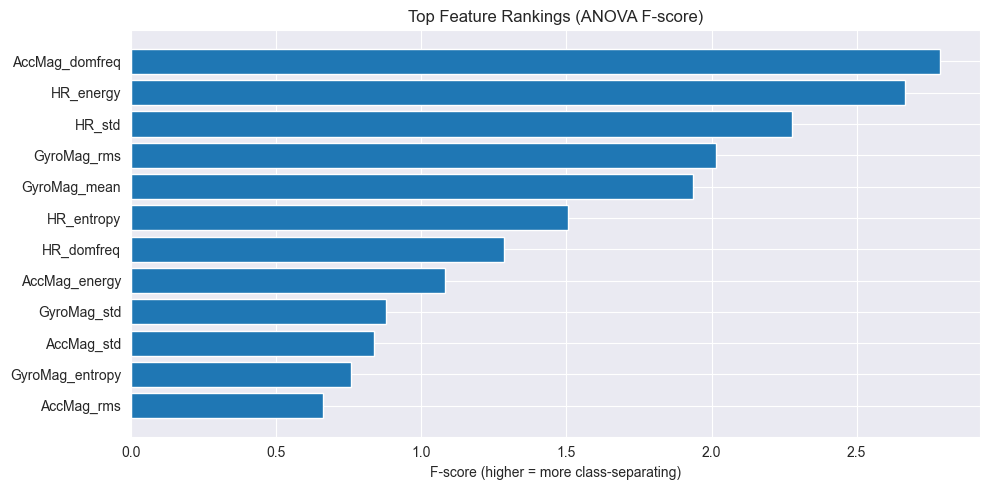

In [7]:
TOPK = 12
top_imp = imp.head(TOPK).sort_values(ascending=True)

plt.figure(figsize=(10,5))
plt.barh(top_imp.index, top_imp.values)
plt.title("Top Feature Rankings (ANOVA F-score)")
plt.xlabel("F-score (higher = more class-separating)")
plt.tight_layout()
plt.show()

C:\Users\azure\AppData\Local\Temp\ipykernel_51152\3043488976.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=le.classes_, showfliers=False)
C:\Users\azure\AppData\Local\Temp\ipykernel_51152\3043488976.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=le.classes_, showfliers=False)
C:\Users\azure\AppData\Local\Temp\ipykernel_51152\3043488976.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=le.classes_, showfliers=False)
C:\Users\azure\AppData\Local\Temp\ipykernel_51152\3043488976.py:10: MatplotlibDeprecationWarning: The 'labels' paramet

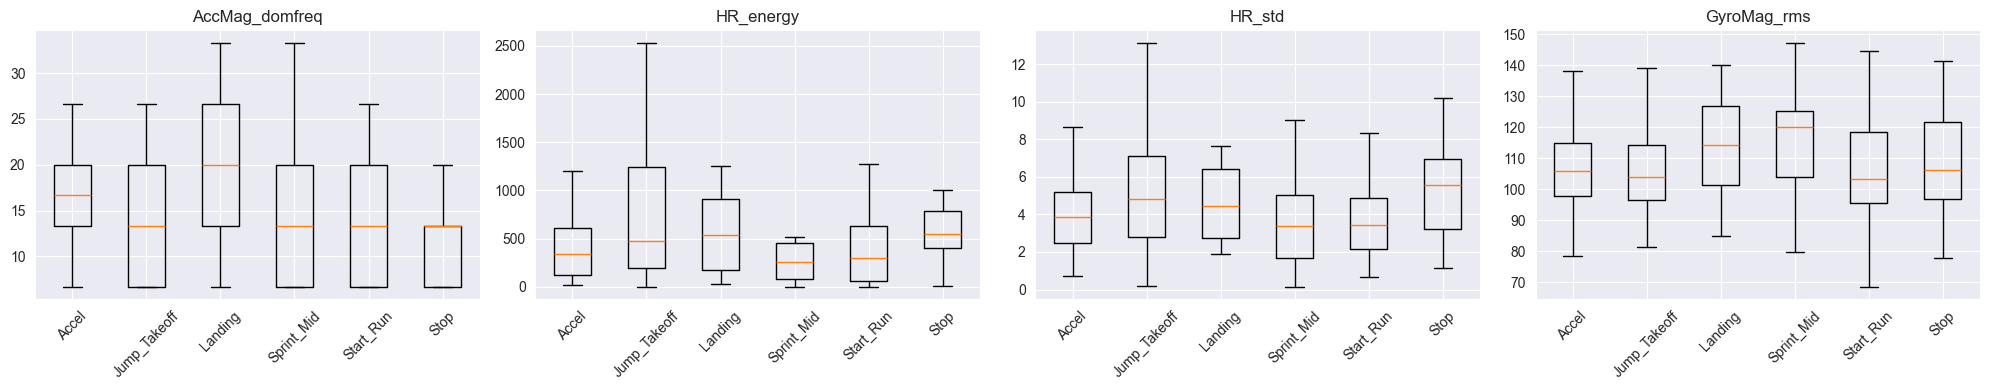

In [8]:
top_feats = imp.head(4).index.tolist()

fig, axes = plt.subplots(1, len(top_feats), figsize=(5*len(top_feats), 4), sharey=False)
if len(top_feats) == 1:
    axes = [axes]

for ax, feat in zip(axes, top_feats):
    # boxplot by label
    data = [features.loc[features["label"] == lab, feat].dropna().values for lab in le.classes_]
    ax.boxplot(data, labels=le.classes_, showfliers=False)
    ax.set_title(feat)
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

In [10]:
OUT_DIR = Path("../data/features")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_PATH = OUT_DIR / "features_windows_1p5s.csv"
features.to_csv(OUT_PATH, index=False)

print("Saved feature table:", OUT_PATH)

Saved feature table: ..\data\features\features_windows_1p5s.csv


### Concise interpretation (rubric)
We extracted window-level features from AccMag, GyroMag, and heart rate signals using both time-domain statistics (mean, standard deviation, RMS, and zero-crossing rate) and frequency-domain descriptors (dominant frequency, spectral energy, and spectral entropy). These features summarize motion intensity, variability, rhythmic patterns, and signal complexity within each window, making the data suitable for classical machine-learning models. We ranked features using ANOVA F-scores, which quantify how strongly each feature separates activity classes, and visualized the top-ranked features to confirm that different activities produce distinct distributions.